In [1]:
import numpy as np
import pandas as pd
import os
import scipy
import tensorflow as tf
import keras

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from math import sqrt

from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import MinMaxScaler

from statistics import mean

from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import asarray

from keras import backend as K
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv1D
#from keras.layers import Conv1DTranspose
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import UpSampling1D

In [2]:
#Función para calcular las veces que duerme el paciente en nuestro set de datos
def numdays(data): 
    days = int()
    for j in range (len(data)-1):
        if data.iloc[j][3] == 0 and data.iloc[j][4] == 0:
                days = days + 1
        else:
                continue
    return days

In [3]:
#Función para convertir los datos de Glucosa en sangre al formato de la LSTM
def dataprocesshours (dataset):   
    #Cuantos datos del set de datos leemos
    timesteps = dataset.shape[0]-1   
    rows  = numdays(dataset)*int(24/hourstoprocess)
    processed = np.ones((rows, (hourstoprocess*12)))
    if workwith=='OHIO':
        Glucoseposition = 6
    elif workwith=='BCN':
        Glucoseposition = 6
    j = 0
    i = 0
    k = 0           
    for j in range (timesteps):
        if k == rows:           
            break
        else: 
            if i < (hourstoprocess*12)-1:
                processed[k][i] = dataset.iloc[j][Glucoseposition]
                i = i + 1
            elif i == (hourstoprocess*12)-1:
                processed[k][i] = dataset.iloc[j][Glucoseposition]
                k = k + 1
                i = 0
    return processed

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    #model.add(Dense(288, activation=mapping_to_target_range, input_dim=latent_dim))
    model.add(Dense(14400, activation='relu', input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((1, 14400)))
    model.add(UpSampling1D())
    model.add(Conv1D(288, 1, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dense(288, activation=mapping_to_target_range))
    model.add(UpSampling1D())
    model.add(Conv1D(288, 1, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    #model.add(Reshape((64)))
    #model.add(Dense(288,activation='linear'))
    #model.add(LeakyReLU(alpha=0.01))
    #model.add(Dense(288, activation='relu'))
    model.summary()
    return model

In [5]:
# define the standalone discriminator model
def define_discriminator():
    model = Sequential()
    
    model.add(Dense(288, activation='linear', input_dim=288))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((1, 288)))
    model.add(Conv1D(288, 1, activation='linear'))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))
    model.add(Conv1D(128, 1, activation='linear', padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=lr, beta_1=0.5)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], size = n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=lr, beta_1=0.5)
    model.compile(loss=loss, optimizer='adam')
    return model

In [9]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs, n_batch, n_eval):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_epochs):
        
        # prepare real samples
        x_real, y_real = generate_real_samples(dataset, half_batch)
        
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)           
            
        _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
        _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

        discri_prediction_fake = discriminator.predict(x_fake)
        discri_prediction_real = discriminator.predict(x_real)
        if i == 0:
            
            real_w = hypocount(x_real)[0]
            real_s = hypocount(x_real)[1]
            real_nohypo = hypocount(x_real)[3]
            
        if i%n_eval == 0:
            
            print('Iteration')
            print(i)
            print(' ')
            print('Fake:')
            print(discri_prediction_fake[:10])
            print(' ')
            print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
            print(' ')
            print('Real:')
            print(discri_prediction_real[:10])
            print(' ')
            
            not_valid = hypocount(fake_smoothing(x_fake))[2]
            fake_w = hypocount(fake_smoothing(x_fake))[0]
            fake_s = hypocount(fake_smoothing(x_fake))[1]
            
            print('real weak hypos:', real_w)
            print('fake weak hypos:', fake_w)
            print('real strong hypos:', real_s)
            print('fake strong hypos:', fake_s)
            print('NON VALID DATA:', not_valid)
            print(' ')
            print('NO HYPO REAL DATA:', real_nohypo)
            print('NO HYPO FAKE DATA:', hypocount(fake_smoothing(x_fake))[3])

            if (abs(real_w-fake_w)/half_batch) < 0.1 and (abs(real_s-fake_s)/half_batch < 0.1) and (not_valid/half_batch<0.1):
                #'''and (not_valid/half_batch < 0.15)'''
                print('VALID SOLUTION ACHIEVED AT: '+str(i)+' EPOCHS')
                # example of calculating the js divergence between two mass functions
                corr_matrix_js_pq = np.ones((n_samples,n_samples))
                corr_matrix_js_pq_real = np.ones((n_samples,n_samples))
                corr_matrix_js_pq_fake = np.ones((n_samples,n_samples))
                fake_smooth= fake_smoothing(x_fake)
                for a in range (half_batch):
                    for j in range(half_batch):

                        p=asarray(x_real[a])
                        q=asarray(fake_smooth[j])
                        corr_matrix_js_pq[a][j] = jensenshannon(p, q, base=2)

                for a in range (half_batch):
                    for j in range(half_batch):

                        p=asarray(x_real[a])
                        q=asarray(x_real[j])
                        corr_matrix_js_pq_real[a][j] = jensenshannon(p, q, base=2)
                        
                        p=asarray(fake_smooth[a])
                        q=asarray(fake_smooth[j])
                        corr_matrix_js_pq_fake[a][j] = jensenshannon(p, q, base=2)
                
                mean_rf =(np.around(np.nanmean(corr_matrix_js_pq), decimals=3))
                mean_rr =(np.around(np.nanmean(corr_matrix_js_pq_real), decimals=3))
                mean_ff =(np.around(np.nanmean(corr_matrix_js_pq_fake), decimals=3))
                
                if (abs(mean_rf-mean_rr)/mean_rr)<=0.15 and (abs(mean_ff-mean_rr)/mean_rr)<=0.40:
                    print('Variate Distribution')
                    directory = direct+'MODELS'
                    filename = 'generator_model_conv1D'+'COMPLETED_MODEL'+workwith+str(hourstoprocess)+'h.h5'
                    generator.save(os.path.join(directory, filename))
                    print('VALID MODEL SAVED')
                    
                
            plt.plot(x_fake[0])
            plt.plot(x_fake[1])
            plt.plot(x_fake[2])
            plt.show()
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        x, y = vstack((x_real, x_fake)), vstack((y_real, y_fake))
        d_loss, _ = d_model.train_on_batch(x, y)
        g_loss = gan_model.train_on_batch(x_gan, y_gan)           

In [10]:
def readprocessed (datain):
    
    dataout = np.ones((datain.shape[0],datain.shape[1]))  

    for j in range (len(dataout)):
        for i in range (len(dataout[0])):
            dataout[j][i] = datain.iloc[j][i]
            
    return dataout

In [11]:
#Función para interpolar los datos con espacios sin información a causa de fallo con el sensor

def datafill (datain):
    
    auxvector = np.ones(len(datain[0])-1)
    dataout = np.ones((len(datain), len(datain[0])))  

    for j in range (len(datain)):
        
        for i in range (len(auxvector)):
            
            #Vector fila que vamos a interpolar
            auxvector[i] = datain[j][i]
            
            #Si el valor en un punto es 0 (falla no continuada)
            if auxvector[i] == 0:
                auxvector[i] = np.nan
            else:
                continue
            
        #Interpolar los valores que no tenemos    
        auxvector = pd.Series(auxvector)
        auxvector = round(auxvector.interpolate())
        dataout[j][:(len(datain[0])-1)] = auxvector[:]
                
        #Último valor (salida) siempre és igual al entrar que al salir de la función, no se interpola    
        dataout[j][len(datain[0])-1] = datain[j][len(datain[0])-1]
              
    return(dataout)

In [12]:
#Encontrar el valor mayor y menor del set de datos para usarlo al escalar entre 0 y 1
def maxmin(datain):
    
    maximo = 0
    minimo = 0
    valores = np.ones(2)
    for j in range (len(datain)):
        if valores[0] <= max(datain[j]):
            valores[0] = max(datain[j])
        else:
            continue
        if valores[1] >= min(datain[j]):
            valores[1] = min(datain[j])
        else: 
            continue
    return valores

In [13]:
def dataclean(datain,datain2):
    def delatevector(datain):

        delate = [] 
        dataout = np.ones((len(datain), len(datain[0])))  

        for j in range (len(datain)):
            fallida = 0
            if datain[j][0]<40 or datain[j][len(datain[0])-1] < 65 or datain[j][len(datain[0])-2] < 40  or datain[j][len(datain[0])-3] < 40:
                delate.append(j)
            else:
                continue
            for i in range (len(datain[0])):
                #Si hemos obtenido error del sensor durante la noche la media (última columna)
                #es menor de 70 però distinta a 65 (hipoglicemia) por lo tanto también eliminamos estos dato                
                if fallida == rangeclean or datain[j][i] > 500:
                    delate.append(j)
                    break
                elif fallida < rangeclean:
                    if datain[j][i] < 40: 
                        fallida = fallida + 1
                    else:
                        continue
                else:
                    continue
        return delate
    delate = delatevector(datain)
    dataout=np.delete(datain2,delate, 0)
    return(dataout)

In [14]:
#Convertir los datos con valores np.nan a datos con 0
def nantovalue(value):       
    if np.isnan(value) == True:
        value = 0
    return value

In [15]:
def mapping_to_target_range(x, target_min=41, target_max=499) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = (target_max-target_min )/2.
    return  x02 * scale + target_min

In [16]:
def wasserstein_loss(y_true, y_pred):
    return tf.math.reduce_mean(y_true * y_pred)

In [17]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt((K.mean(K.square(y_pred - y_true), axis=-1)))

In [18]:
# create and save a plot of generated images (reversed grayscale)
def save_plot1(model, n):
    # plot images
    latent_points = generate_latent_points(latent_dim, 100)
    examples = model.predict(latent_points)
    hourtick=np.zeros((examples.shape[1]))
    for j in range(examples.shape[1]):
        if j%24==0:
            hourtick[j]=50
    for i in range(n * n):
        if i == 2:
            plt.title('Fake Data: 2h')
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        #pyplot.axis('off')
        # plot raw pixel data
        latent_points = generate_latent_points(latent_dim, 100)
        examples = model.predict(latent_points)
        
        fake_smooth = fake_smoothing(examples)
        plt.plot
        #plt.scatter(x_axis,x_fake[1])
        plt.plot(fake_smooth[i], label='Filtered Data')
        #plt.plot(myline, mymodelreal(myline))
        plt.plot(hourtick, label = 'Hour')
        plt.plot(examples[i],label = 'Generated Data')
        
        plt.xticks([])
        #plt.set_xlabel('Hours
        #plt.set_ylabel('Glucose')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

In [19]:
def hypocountrealscale(datain):
    
    valid=True
    range70_500 = 0
    range54_70 = 0
    range40_54 = 0
    range25_40 = 0
    rangeout = 0
    nonvalid = 0
        
    for i in range(datain.shape[0]):
        for j in range (datain.shape[1]):               
            if datain[i][j] >= 70 and datain[i][j] < 500:
                range70_500 = range70_500+1
            elif datain[i][j] >= 54 and datain[i][j] < 70:
                range54_70 = range54_70+1
            elif datain[i][j] > 40 and datain[i][j] < 54:
                range40_54 = range40_54+1
            #Para contar los datos reales con valor 40 (límite del sensor) como adaptados
            elif datain[i][j] >= 25 and datain[i][j] <= 40:
                range25_40=range25_40+1
            elif datain[i][j] < 25 and valid==False:
                rangeout = rangeout+1
            elif datain[i][j] < 25 and valid==True:
                rangeout = rangeout+1
                nonvalid=nonvalid+1
                valid=False
            
                                  
    return (range70_500,  range54_70, range40_54 , range25_40, rangeout, nonvalid)

In [20]:
def hypocount(datain):
    not_valid=0
    w_hypo=0
    s_hypo=0
    nohypo_right = 0
    for i in range(datain.shape[0]):
        w_hypo_event=False
        s_hypo_event=False
        for j in range (datain.shape[1]):
            if (datain[i][j] < 0 or datain[i][j] > 1) and w_hypo_event==False and s_hypo_event==False:
                not_valid = not_valid + 1
                break
            elif (datain[i][j] < 0 or datain[i][j] > 1) and w_hypo_event==True and s_hypo_event==False:
                not_valid = not_valid + 1
                w_hypo = w_hypo -1
                break
            elif (datain[i][j] < 0 or datain[i][j] > 1) and w_hypo_event==False and s_hypo_event==True:
                not_valid = not_valid + 1
                s_hypo = s_hypo-1
                break
            elif (datain[i][j] < 0 or datain[i][j] > 1) and w_hypo_event==True and s_hypo_event==True:
                not_valid = not_valid + 1
                s_hypo = s_hypo-1
                break
            else:
                if datain[i][j]<=0.1522 and  datain[i][j]>0.1086 and w_hypo_event==False and s_hypo_event==False:
                    w_hypo = w_hypo +1
                    w_hypo_event=True
                elif datain[i][j]<=0.1522 and  datain[i][j]>0.1086 and w_hypo_event==True and s_hypo_event==False:
                    w_hypo_event=True
                elif datain[i][j]<=0.1522 and  datain[i][j]>0.1086 and w_hypo_event==True and s_hypo_event==True:
                    w_hypo_event=True
                elif datain[i][j]<=0.1522 and  datain[i][j]<=0.1086 and w_hypo_event==False and s_hypo_event==False:
                    s_hypo_event=True
                    s_hypo = s_hypo +1
                elif datain[i][j]<=0.1522 and  datain[i][j]<=0.1086 and w_hypo_event==True and s_hypo_event==False:
                    s_hypo_event=True
                    s_hypo = s_hypo +1
                    w_hypo = w_hypo -1
                elif datain[i][j]<=0.1522 and  datain[i][j]<=0.1086 and w_hypo_event==True and s_hypo_event==True:
                    s_hypo_event=True
                elif datain[i][j]>0.1522 and w_hypo_event==False and s_hypo_event==False and j==287:
                    nohypo_right = nohypo_right+1

                    
    return (w_hypo,s_hypo,not_valid,nohypo_right)

In [21]:
def fake_smoothing(fake):
    fake_smooth=np.ones((fake.shape[0],fake.shape[1]))
    for i in range (fake.shape[0]):
        fake_smooth[i] = savgol_filter(fake[i], 21, 9)  # high frequency noise removed
    return fake_smooth

In [22]:
def openfile(directory_read):
    df = pd.read_csv(directory_read, sep = ';')
    df = readprocessed(df)
    #Convertir los datos con valores np.nan a datos con 0
    for i in range (len(df)):
        for j in range (len(df[0])):
            df[i][j] = nantovalue(df[i][j])
    rangeclean=12
    df = dataclean(df,df)
    df = datafill(df)
    print('Archivo cargado y datos filtrados')
    return df

In [23]:
def rawtoprocess():
    print ('Procesando:'+workwith)
    directory = direct+'CSV//'+workwith+'//PROCESSED//'
    GlucoseProcessed = False
    for filename in os.listdir(directory):
        if (directory+filename).endswith((str(hourstoprocess)+'h.csv')): 
            GlucoseProcessed = True
            print('Los Datos ya existen')
            break 
        else:
            GlucoseProcessed = False
            print('Buscando datos con el mismo nombre')
            directory =  direct+'CSV//'+workwith+'//RAW//'
    #Si no existen los archivos de datos procesados procesarlos.
    #Unir los datos procesados de cada paciente en el directorio de pacientes
    #En un solo archivo CSV
    if GlucoseProcessed == False:
        for filename in os.listdir(directory):
            print(filename)
            dataset = pd.read_csv((directory+filename), sep = ';')
            Glucose = dataprocesshours(dataset)
            pd.DataFrame(Glucose).to_csv(direct+'CSV//'+workwith+'//PROCESSED//Glucose_'+workwith+str(hourstoprocess)+'h.csv', header = False, mode = 'a', sep = ';', index = False, line_terminator='\n', float_format='%.3f')


In [24]:
def paramcheck():
    if workwith=='BCN':
        BCN=True
        OHIO=False
    elif workwith=='OHIO':
        OHIO=True
        BCN=False
    else:
        print('No hay datos con el nombre especificado')

    if 24%hourstoprocess==0:
        print ('Horas acceptadas')
        if process == True:
            rawtoprocess()
            print('PROCESADO COMPLETADO')
    else:
        print('Las horas deben der divisor de 24')
        print('para un processado de datos correcto')
        print(' ')
        print('NO PROCESANDO')

In [25]:
def evaluation():    
    for i in range (n_samples):
        for j in range(n_samples):

            p=asarray(x_real[i])
            q=asarray(fake_smooth[j])

            sample = pd.Series(fake_smooth[i])
            sample_real = pd.Series(x_real[i])

            var_matrix_pq[i][j] = explained_variance_score(p,q)

            corr_matrix_js_pq[i][j] = jensenshannon(p, q, base=2)
            corr_matrix_kl_pq[i][j] = sum(kl_div(p, q))

            mad_matrix_fake[i] = sample.mad()
            sd_matrix_fake[i] = sample.std(ddof=0)
            mad_matrix_real[i] = sample_real.mad()
            sd_matrix_real[i] = sample_real.std(ddof=0)
            zs_matrix_fake[i] = zscore(fake_smooth[i])
            zs_matrix_real[i] = zscore(x_real[i])

    for i in range (n_samples):
        for j in range(n_samples):

            p=asarray(x_real[i])
            q=asarray(x_real[j])

            corr_matrix_js_pq_real[i][j] = jensenshannon(p, q, base=2)
            corr_matrix_kl_pq_real[i][j] = sum(kl_div(p, q))

            var_matrix_pq_real[i][j] = explained_variance_score(p,q)

            p=asarray(fake_smooth[i])
            q=asarray(fake_smooth[j])   

            corr_matrix_js_pq_fake[i][j] = jensenshannon(p, q, base=2)
            corr_matrix_kl_pq_fake[i][j] = sum(kl_div(p, q))
            var_matrix_pq_fake[i][j] = explained_variance_score(p,q)

In [49]:
#Ordenador con el que estoy trabajando
machine = 'laptop'

#¿Queremos procesar los datos?
process = True

#¿Cuantas horas queremos procesar?
hourstoprocess = 24

#Cantidad de datos 0/nan limite para considerar un dia no acceptable
rangeclean=12

#Tipo de datos para trabajar
workwith='BCN'

#¿Queremos entrenar el modelo?
training_model=True

#¿Los datos ya se han cargado?
opened=False

#¿Cuantas iteraciones vamos a usar?
n_epoch = 15000

#Función de error a usar
loss='binary_crossentropy'

#Mostrar los resultados cada n_eval iteraciones
n_eval = 250

#Learning rate
lr=0.0001

#Tamaño del espacio latente
latent_dim = 500

#Muestras a propagar
n_samples= 64



if machine=='laptop':
    direct='C://Users//josep//Desktop//TFG//'
elif machine == 'PC':
    direct='E://JOSEP//Escritorio//TFG//'
    
rawtoprocess()   
rangeclean=12
directory_read = direct+'CSV//'

complete_dir=(directory_read+workwith+'//PROCESSED//Glucose_'+workwith +str(hourstoprocess)+'h.csv')
df = openfile(complete_dir)

Procesando:BCN
Buscando datos con el mismo nombre
Buscando datos con el mismo nombre
Los Datos ya existen
Archivo cargado y datos filtrados


In [50]:
dataset=df
#scaler = MinMaxScaler(feature_range=[0, 1])
#minmax=scaler.fit(dataset)
#dataset=scaler.transform(dataset)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 288)               83232     
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 288)               0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 1, 288)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1, 288)            83232     
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 1, 288)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 1, 128)            36992     
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 1, 128)          

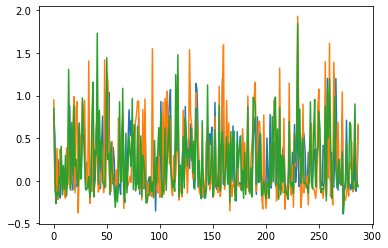

Iteration
250
 
Fake:
[[0.62082016]
 [0.39334893]
 [0.42577815]
 [0.45759955]
 [0.49433902]
 [0.4167849 ]
 [0.41999486]
 [0.4408376 ]
 [0.3678466 ]
 [0.47270864]]
 
>Accuracy real: 97%, fake: 88%
 
Real:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


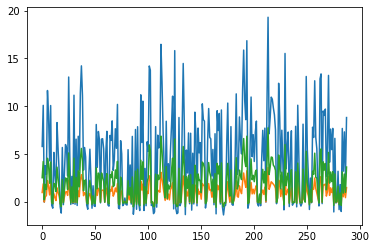

Iteration
500
 
Fake:
[[0.1846371 ]
 [0.2223346 ]
 [0.21215633]
 [0.20693573]
 [0.08489889]
 [0.10391694]
 [0.16995695]
 [0.18739426]
 [0.25907803]
 [0.24218708]]
 
>Accuracy real: 100%, fake: 100%
 
Real:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


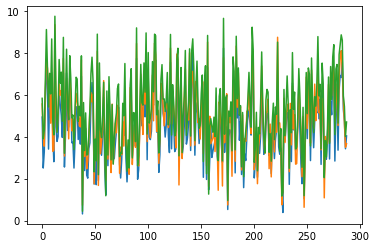

Iteration
750
 
Fake:
[[0.16343239]
 [0.15915295]
 [0.21631366]
 [0.22385141]
 [0.18555486]
 [0.1892555 ]
 [0.2216542 ]
 [0.24389666]
 [0.1662952 ]
 [0.15829432]]
 
>Accuracy real: 97%, fake: 100%
 
Real:
[[0.99972045]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


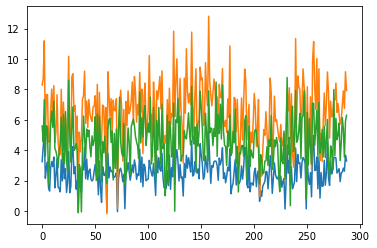

Iteration
1000
 
Fake:
[[0.5555117 ]
 [0.77979565]
 [0.41967762]
 [0.3164336 ]
 [0.96441865]
 [0.35856992]
 [0.08059222]
 [0.9832036 ]
 [0.3915464 ]
 [0.8065572 ]]
 
>Accuracy real: 100%, fake: 44%
 
Real:
[[1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [1.      ]
 [0.999988]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


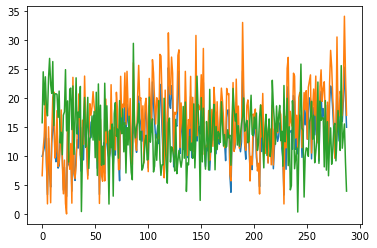

Iteration
1250
 
Fake:
[[0.08800232]
 [0.10562581]
 [0.10534284]
 [0.1230326 ]
 [0.1220156 ]
 [0.28285024]
 [0.19041777]
 [0.11238626]
 [0.07997647]
 [0.11271936]]
 
>Accuracy real: 91%, fake: 100%
 
Real:
[[1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99999964]
 [0.25808924]
 [1.        ]
 [0.9999795 ]
 [1.        ]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


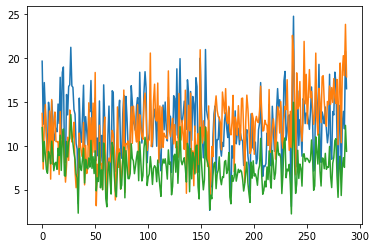

Iteration
1500
 
Fake:
[[0.04287791]
 [0.0469822 ]
 [0.0870007 ]
 [0.02557012]
 [0.04664981]
 [0.0912964 ]
 [0.07465488]
 [0.07882786]
 [0.06296962]
 [0.19389594]]
 
>Accuracy real: 100%, fake: 100%
 
Real:
[[1.       ]
 [1.       ]
 [1.       ]
 [0.9999968]
 [0.7291032]
 [1.       ]
 [0.9800617]
 [1.       ]
 [1.       ]
 [0.9999019]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


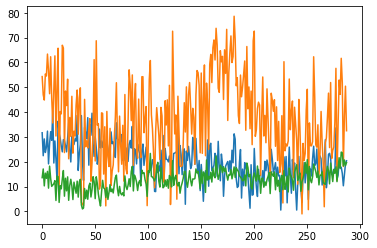

Iteration
1750
 
Fake:
[[0.03441823]
 [0.08385602]
 [0.06533402]
 [0.04501861]
 [0.10837761]
 [0.03518507]
 [0.01805022]
 [0.07170209]
 [0.04194787]
 [0.06084001]]
 
>Accuracy real: 81%, fake: 100%
 
Real:
[[0.30155745]
 [0.99999535]
 [0.8919481 ]
 [0.99999166]
 [0.9809152 ]
 [0.9988768 ]
 [0.44669163]
 [0.99999964]
 [0.99815875]
 [0.95808494]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


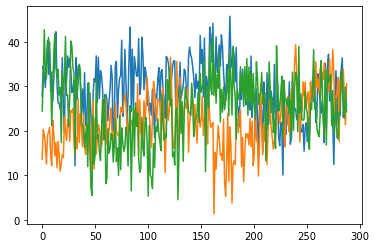

Iteration
2000
 
Fake:
[[0.02906519]
 [0.02144513]
 [0.00999686]
 [0.06314069]
 [0.01888141]
 [0.01354226]
 [0.04209194]
 [0.02557307]
 [0.03936982]
 [0.03506708]]
 
>Accuracy real: 88%, fake: 100%
 
Real:
[[1.        ]
 [0.9979175 ]
 [0.9987023 ]
 [0.23418939]
 [0.999995  ]
 [1.        ]
 [0.7438891 ]
 [0.9431789 ]
 [0.9999638 ]
 [0.9660562 ]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


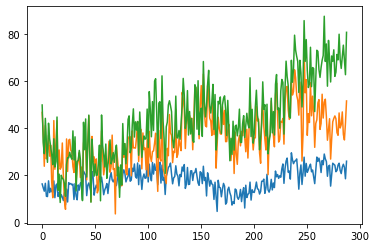

Iteration
2250
 
Fake:
[[0.09236565]
 [0.0586482 ]
 [0.01568481]
 [0.02593207]
 [0.14937025]
 [0.03547418]
 [0.19047442]
 [0.05325246]
 [0.05147752]
 [0.06333697]]
 
>Accuracy real: 97%, fake: 100%
 
Real:
[[0.9927712 ]
 [0.999995  ]
 [0.9974974 ]
 [0.99926037]
 [0.9987588 ]
 [0.999021  ]
 [0.9972306 ]
 [1.        ]
 [0.99999046]
 [0.9998989 ]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


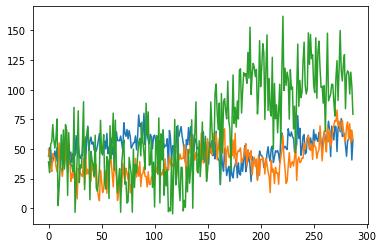

Iteration
2500
 
Fake:
[[0.05502987]
 [0.05268466]
 [0.05689862]
 [0.03999147]
 [0.03837553]
 [0.10404778]
 [0.02472848]
 [0.10586837]
 [0.04437131]
 [0.05793935]]
 
>Accuracy real: 78%, fake: 100%
 
Real:
[[0.74394876]
 [0.9968081 ]
 [0.9997541 ]
 [1.        ]
 [0.21059138]
 [0.9448485 ]
 [0.9662396 ]
 [1.        ]
 [0.9999783 ]
 [0.99957836]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


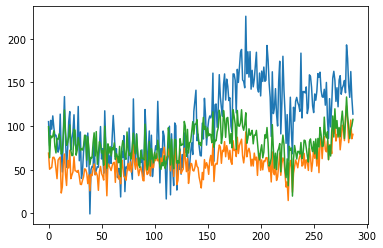

Iteration
2750
 
Fake:
[[0.05602437]
 [0.0089778 ]
 [0.00823995]
 [0.0198485 ]
 [0.0481168 ]
 [0.05634439]
 [0.01856154]
 [0.02649644]
 [0.017129  ]
 [0.02403182]]
 
>Accuracy real: 81%, fake: 100%
 
Real:
[[0.01121777]
 [0.95355105]
 [1.        ]
 [0.9835634 ]
 [1.        ]
 [0.06011367]
 [0.99784565]
 [0.0763416 ]
 [0.99693644]
 [0.46858698]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


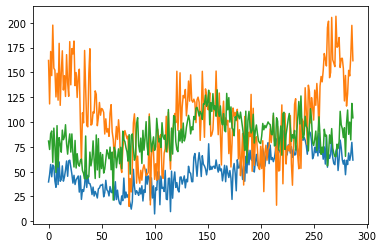

Iteration
3000
 
Fake:
[[0.0257895 ]
 [0.25619304]
 [0.0042643 ]
 [0.00510055]
 [0.0356186 ]
 [0.01801303]
 [0.01085484]
 [0.00472981]
 [0.0579052 ]
 [0.04500762]]
 
>Accuracy real: 78%, fake: 97%
 
Real:
[[0.98272014]
 [0.9593376 ]
 [1.        ]
 [0.87914   ]
 [0.286158  ]
 [0.9992895 ]
 [0.8575807 ]
 [0.9824127 ]
 [0.9987056 ]
 [0.6367885 ]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


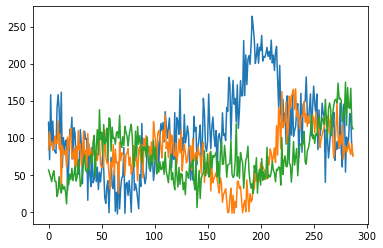

Iteration
3250
 
Fake:
[[0.08628601]
 [0.0520089 ]
 [0.05616722]
 [0.0411475 ]
 [0.04483214]
 [0.04433295]
 [0.12480906]
 [0.307128  ]
 [0.16376823]
 [0.55073845]]
 
>Accuracy real: 84%, fake: 84%
 
Real:
[[0.30096853]
 [0.870931  ]
 [0.88455206]
 [0.88455206]
 [0.70288014]
 [0.99999976]
 [0.99658036]
 [0.49981067]
 [0.7520835 ]
 [0.6813803 ]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


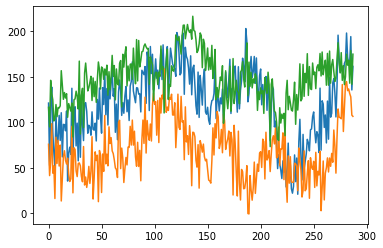

Iteration
3500
 
Fake:
[[0.03941587]
 [0.01767391]
 [0.00341451]
 [0.00431749]
 [0.00771409]
 [0.05429924]
 [0.08379689]
 [0.04142907]
 [0.01363686]
 [0.05430436]]
 
>Accuracy real: 62%, fake: 94%
 
Real:
[[0.07583722]
 [0.9558628 ]
 [0.58748204]
 [0.92942065]
 [0.05422631]
 [0.98140323]
 [0.9875591 ]
 [0.39111668]
 [0.30470318]
 [0.12430087]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


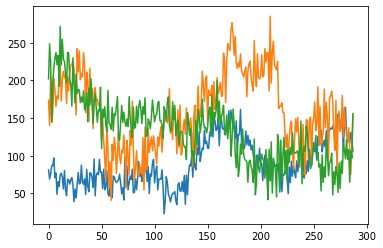

Iteration
3750
 
Fake:
[[0.08779901]
 [0.32039982]
 [0.0668771 ]
 [0.19981548]
 [0.10928032]
 [0.07531074]
 [0.26340982]
 [0.32071635]
 [0.12091175]
 [0.11816821]]
 
>Accuracy real: 50%, fake: 91%
 
Real:
[[0.2506116 ]
 [0.5846013 ]
 [0.5674703 ]
 [0.19809589]
 [0.13866967]
 [0.47329032]
 [0.6812135 ]
 [0.2506116 ]
 [0.02011472]
 [0.6797893 ]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


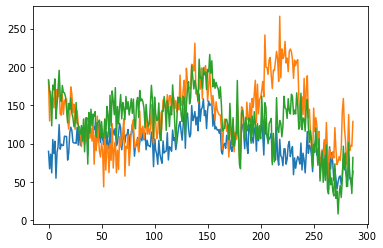

Iteration
4000
 
Fake:
[[0.04844618]
 [0.02637243]
 [0.03131706]
 [0.07618847]
 [0.02128267]
 [0.04617649]
 [0.15241349]
 [0.01469013]
 [0.23583934]
 [0.06667846]]
 
>Accuracy real: 47%, fake: 97%
 
Real:
[[0.5053237 ]
 [0.6458365 ]
 [0.13798708]
 [0.31349856]
 [0.5534188 ]
 [0.10596353]
 [0.03710845]
 [0.04650152]
 [0.99508655]
 [0.78677785]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


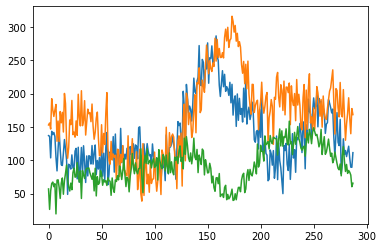

Iteration
4250
 
Fake:
[[0.10137877]
 [0.15993205]
 [0.21750343]
 [0.01480103]
 [0.31457913]
 [0.01177269]
 [0.05818996]
 [0.02817684]
 [0.02258706]
 [0.0474458 ]]
 
>Accuracy real: 47%, fake: 91%
 
Real:
[[0.7110146 ]
 [0.27341396]
 [0.02857986]
 [0.6151867 ]
 [0.959225  ]
 [0.98649657]
 [0.9999999 ]
 [0.05688664]
 [0.34774417]
 [0.7099812 ]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


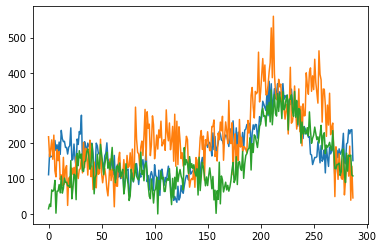

Iteration
4500
 
Fake:
[[3.1727552e-04]
 [9.7715646e-02]
 [3.4486741e-02]
 [7.3392446e-05]
 [4.5546889e-03]
 [7.3013633e-02]
 [1.9355667e-01]
 [2.1754166e-01]
 [5.4129577e-01]
 [3.6482960e-02]]
 
>Accuracy real: 44%, fake: 88%
 
Real:
[[0.06808397]
 [0.6705942 ]
 [0.14511672]
 [0.14140591]
 [0.99874616]
 [0.4514431 ]
 [0.91501087]
 [0.4438998 ]
 [0.59680843]
 [0.13686675]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


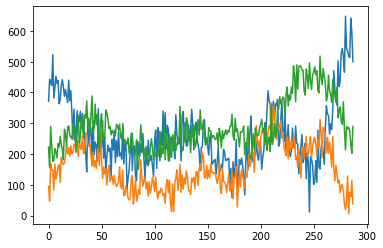

Iteration
4750
 
Fake:
[[0.05821243]
 [0.34427738]
 [0.1387319 ]
 [0.44205838]
 [0.04842207]
 [0.5427322 ]
 [0.05734062]
 [0.05572638]
 [0.18216914]
 [0.14276376]]
 
>Accuracy real: 38%, fake: 94%
 
Real:
[[0.48753837]
 [0.10163125]
 [0.13889205]
 [0.94412845]
 [0.99444985]
 [0.22958755]
 [0.2575873 ]
 [0.7834619 ]
 [0.5979012 ]
 [0.30633578]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


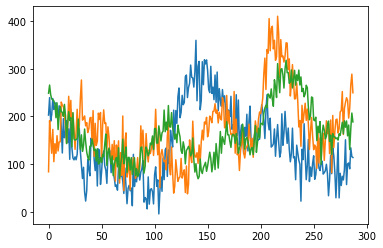

Iteration
5000
 
Fake:
[[0.00634924]
 [0.0693495 ]
 [0.01156291]
 [0.31066683]
 [0.00541273]
 [0.06179869]
 [0.00034985]
 [0.29866603]
 [0.26118305]
 [0.01217777]]
 
>Accuracy real: 28%, fake: 78%
 
Real:
[[0.10276207]
 [0.15648586]
 [0.10191849]
 [0.4712518 ]
 [0.14618948]
 [0.9160979 ]
 [0.12975991]
 [0.10276207]
 [0.97015893]
 [0.06668597]]
 
real weak hypos: 0
fake weak hypos: 0
real strong hypos: 0
fake strong hypos: 0
NON VALID DATA: 32
 
NO HYPO REAL DATA: 0
NO HYPO FAKE DATA: 0


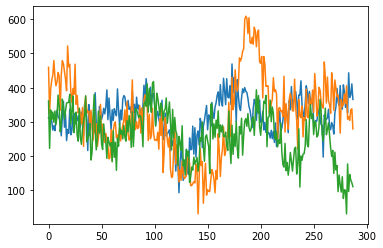

KeyboardInterrupt: 

In [51]:
n_batch = n_samples
penalty = 1
# train model
if training_model==True:
    # create the discriminator
    discriminator = define_discriminator()
    # create the generator
    generator = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(generator, discriminator)
    if machine == 'PC':
        with tf.device('/gpu:0'):
            train(generator, discriminator, gan_model, latent_dim, n_epoch, n_batch, n_eval)
    elif machine =='laptop':
        train(generator, discriminator, gan_model, latent_dim, n_epoch, n_batch, n_eval)

In [52]:
if training_model==True: 
    directory = direct+'MODELS'
    filename = 'generator_model_conv1D'+workwith+str(hourstoprocess)+'h.h5'
    generator.save(os.path.join(directory, filename))
    print('SAVED')

SAVED


In [55]:
# load model
model = load_model(direct+'MODELS//generator_model_conv1D'+workwith+str(hourstoprocess)+'h.h5')

In [84]:
n_samples=100

x_fake, y_fake = generate_fake_samples(model, latent_dim, n_samples)
x_real, y_real = generate_real_samples(dataset, n_samples)

#x_fake=scaler.inverse_transform(x_fake)
#x_real=scaler.inverse_transform(x_real)

fake_smooth = fake_smoothing(x_fake)
for i in range(fake_smooth.shape[0]):
    for j in range(fake_smooth.shape[1]):
        if fake_smooth[i][j] <=40 and fake_smooth[i][j]>15:
            fake_smooth[i][j] = 40
        elif fake_smooth[i][j] >= 500 and fake_smooth[i][j]<800:
            fake_smooth[i][j] = 500
        elif fake_smooth[i][j] <=0:
            fake_smooth[i][j] = 0.1
            
            
# example of calculating the js divergence between two mass functions
corr_matrix_js_pq = np.ones((n_samples,n_samples))
corr_matrix_kl_pq = np.ones((n_samples,n_samples))
var_matrix_pq = np.ones((n_samples,n_samples))

mad_matrix_fake = np.ones((n_samples))
sd_matrix_fake = np.ones((n_samples))
mad_matrix_real = np.ones((n_samples))
sd_matrix_real = np.ones((n_samples))
zs_matrix_fake = np.ones((n_samples,288))
zs_matrix_real = np.ones((n_samples,288))

corr_matrix_js_pq_real = np.ones((n_samples,n_samples))
corr_matrix_kl_pq_real = np.ones((n_samples,n_samples))
corr_matrix_js_pq_fake = np.ones((n_samples,n_samples))
corr_matrix_kl_pq_fake = np.ones((n_samples,n_samples))
var_matrix_pq_real = np.ones((n_samples,n_samples))
var_matrix_pq_fake = np.ones((n_samples,n_samples))

evaluation()

In Real-Real and Fake-Fake matrix values of equal
distributions are omited when calculating the mean
 
 
 
JS distance real-fake:
 
[[0.317 0.305 0.284 ... 0.298 0.269 0.297]
 [0.159 0.286 0.115 ... 0.131 0.298 0.183]
 [0.358 0.222 0.328 ... 0.323 0.319 0.31 ]
 ...
 [0.254 0.228 0.229 ... 0.217 0.263 0.201]
 [0.213 0.169 0.168 ... 0.144 0.215 0.211]
 [0.252 0.308 0.259 ... 0.246 0.383 0.233]]
 
 
 


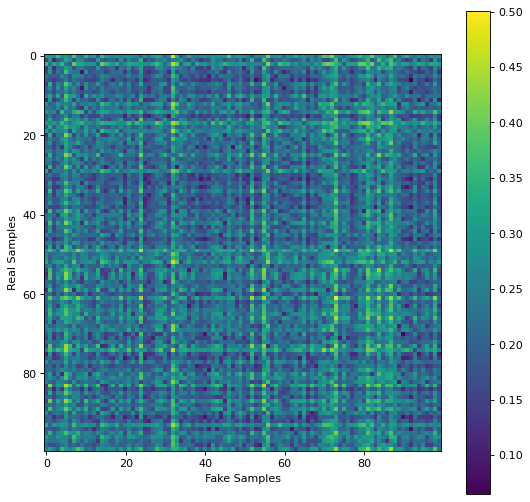

Average ----> 0.235
 
 
 
JS distance real-real:
 
[[0.    0.348 0.259 ... 0.188 0.282 0.364]
 [0.348 0.    0.354 ... 0.276 0.194 0.218]
 [0.259 0.354 0.    ... 0.217 0.269 0.287]
 ...
 [0.188 0.276 0.217 ... 0.    0.214 0.27 ]
 [0.282 0.194 0.269 ... 0.214 0.    0.243]
 [0.364 0.218 0.287 ... 0.27  0.243 0.   ]]
 


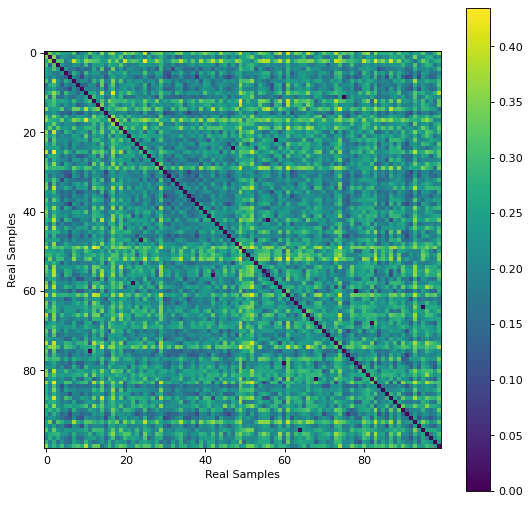

Average ----> 0.233
 
 
 
JS distance fake-fake:
 
[[0.    0.328 0.131 ... 0.131 0.299 0.126]
 [0.328 0.    0.258 ... 0.239 0.222 0.29 ]
 [0.131 0.258 0.    ... 0.085 0.226 0.157]
 ...
 [0.131 0.239 0.085 ... 0.    0.231 0.134]
 [0.299 0.222 0.226 ... 0.231 0.    0.273]
 [0.126 0.29  0.157 ... 0.134 0.273 0.   ]]
 


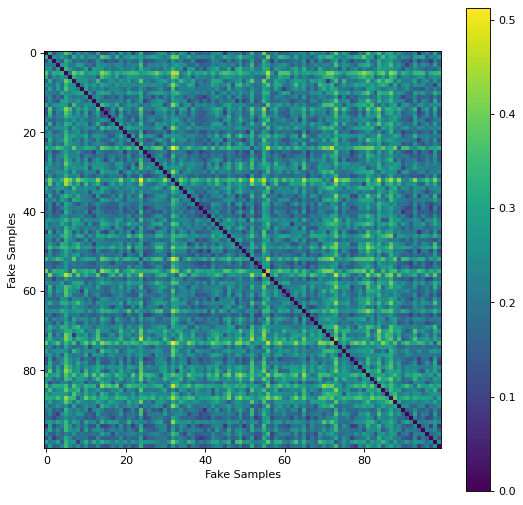

 
Average ----> 0.236


In [85]:
#In probability theory and statistics, the Jensen–Shannon divergence is a method 
#of measuring the similarity between two probability distributions. It is also known as
#information radius (IRad) or total divergence to the average. 
#It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, 
#including that it is symmetric and it always has a finite value. 
#The square root of the Jensen–Shannon divergence is a metric often referred to as Jensen-Shannon distance

img_size = 8
print('In Real-Real and Fake-Fake matrix values of equal')
print('distributions are omited when calculating the mean')
print(' ')
print(' ')
print(' ')
#JS-pq
print('JS distance real-fake:')
print(' ')
print(np.around(corr_matrix_js_pq, decimals=3))
print(' ')
print(' ')
#print('Average ---->', np.around(np.mean(corr_matrix_js_pq), decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_js_pq)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Real Samples')
plt.show()
corr_matrix_js_pq[corr_matrix_js_pq == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_js_pq), decimals=3))
print(' ')
print(' ')
print(' ')
print('JS distance real-real:')
print(' ')
print(np.around(corr_matrix_js_pq_real, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_js_pq_real)
plt.colorbar()
plt.xlabel('Real Samples')
plt.ylabel('Real Samples')
plt.show()
corr_matrix_js_pq_real[corr_matrix_js_pq_real == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_js_pq_real), decimals=3))
print(' ')
print(' ')
print(' ')
print('JS distance fake-fake:')
print(' ')
print(np.around(corr_matrix_js_pq_fake, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_js_pq_fake)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Fake Samples')
plt.show()
print(' ')
corr_matrix_js_pq_fake[corr_matrix_js_pq_fake == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_js_pq_fake), decimals=3))

In Real-Real and Fake-Fake matrix values of equal
distributions are omited when calculating the mean
 
 
 
KL distance real-fake:
 
[[31729.011 14442.617 18929.305 ... 12968.513  8952.662 11534.187]
 [17534.429 14157.081  7206.904 ...  2840.978 17986.503  4439.927]
 [32780.902  7377.714 20147.788 ... 13935.056 14301.868 11780.349]
 ...
 [30581.638  9491.331 17614.945 ...  8917.524  7682.01   6698.028]
 [16298.609  4725.423  6844.514 ...  3290.436 15753.609  7494.243]
 [25737.574 13913.252 15986.335 ...  8460.146 20881.158  6805.344]]
 


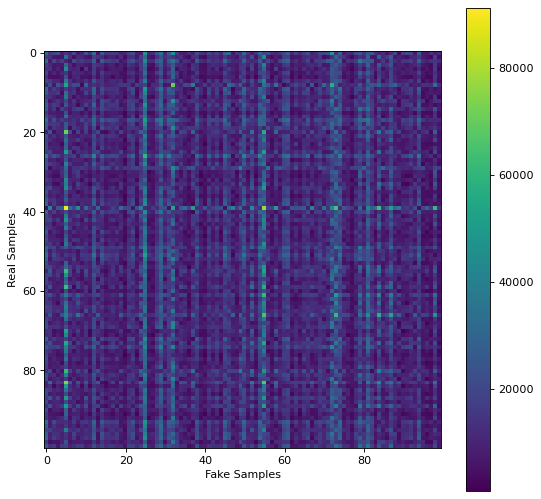

 
Average ----> 13529.941
 
 
 
KL distance real-real:
 
9758.01


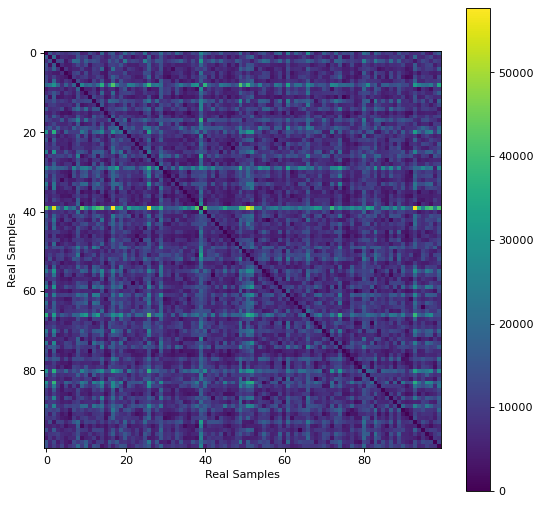

 
Average ----> 9870.534
 
 
 
KL distance fake-fake:
 
[[    0.    43696.883  7002.881 ... 15354.114 69405.812 18374.393]
 [25267.136     0.    11924.465 ...  8232.625 14724.981 13084.202]
 [ 5875.366 19085.955     0.    ...  4228.201 32775.229  9509.117]
 ...
 [12027.142 10135.424  3620.916 ...     0.    17324.988  3063.451]
 [34679.8   10344.573 19179.259 ... 10214.54      0.    10577.575]
 [13971.017 13169.386  7443.207 ...  2622.983 17755.701     0.   ]]
 


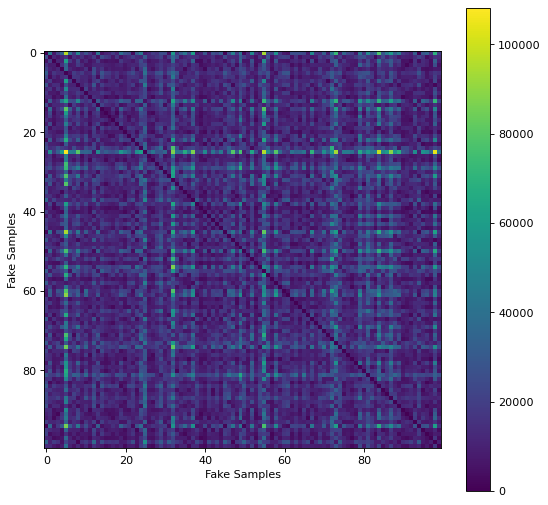

 
Average ----> 16028.943


In [86]:
#KL-pq
#En palabras, es el promedio ponderado de la diferencia 
#logarítmica entre las probabilidades P y Q,
#donde el promedio se toma usando las probabilidades P
print('In Real-Real and Fake-Fake matrix values of equal')
print('distributions are omited when calculating the mean')
print(' ')
print(' ')
print(' ')
print('KL distance real-fake:')
print(' ')
print(np.around(corr_matrix_kl_pq, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_kl_pq)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Real Samples')
plt.show()
print(' ')
corr_matrix_kl_pq[corr_matrix_kl_pq == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_kl_pq), decimals=3))
print(' ')
print(' ')
print(' ')
print('KL distance real-real:')
print(' ')
print(np.around(np.mean(corr_matrix_kl_pq_real), decimals=3))
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_kl_pq_real)
plt.colorbar()
plt.xlabel('Real Samples')
plt.ylabel('Real Samples')
plt.show()
print(' ')
corr_matrix_kl_pq_real[corr_matrix_kl_pq_real == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_kl_pq_real), decimals=3))
print(' ')
print(' ')
print(' ')
print('KL distance fake-fake:')
print(' ')
print(np.around(corr_matrix_kl_pq_fake, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(corr_matrix_kl_pq_fake)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Fake Samples')
plt.show()
print(' ')
corr_matrix_kl_pq_fake[corr_matrix_kl_pq_fake == 0] = np.nan
print('Average ---->', np.around(np.nanmean(corr_matrix_kl_pq_fake), decimals=3))

In Real-Real and Fake-Fake matrix values of equal
distributions are omited when calculating the mean
 
 
 
Variance real-fake:
 
[[-2.33  -1.336 -0.851 ... -0.771 -0.09  -0.683]
 [-1.594 -3.284  0.311 ...  0.186 -1.424 -0.62 ]
 [-2.377 -0.034 -1.012 ... -0.66  -0.293 -0.405]
 ...
 [-6.384 -3.234 -2.61  ... -1.471 -1.273 -0.943]
 [-3.236 -0.059 -0.717 ... -0.065 -0.073 -1.108]
 [-1.516 -1.573 -0.973 ... -0.415 -1.353 -0.095]]
 


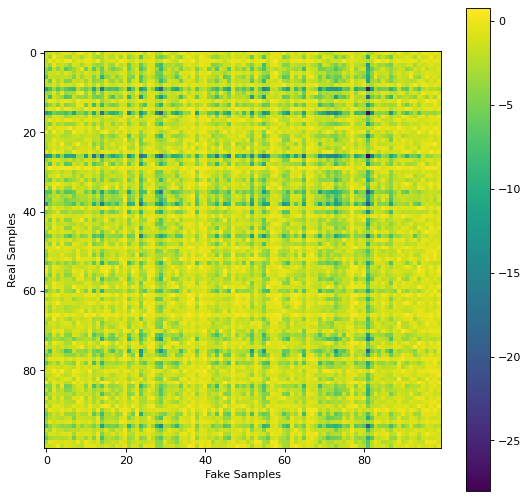

 
Average ----> -2.189
 
 
 
Variance real-real:
 
-1.385


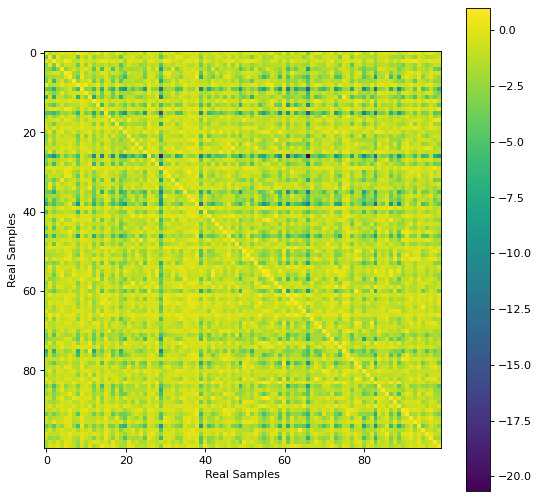

 
Average ----> -1.385
 
 
 
Variance fake-fake:
 
[[ 1.    -2.27   0.054 ...  0.076 -0.804  0.234]
 [-2.442  1.    -0.415 ... -0.048  0.26  -0.644]
 [-2.087 -3.386  1.    ...  0.32  -0.598 -1.102]
 ...
 [-3.587 -3.944 -0.035 ...  1.    -1.09  -0.806]
 [-5.191 -1.411 -0.681 ... -0.445  1.    -1.333]
 [-2.455 -6.044 -1.904 ... -0.641 -2.066  1.   ]]
 


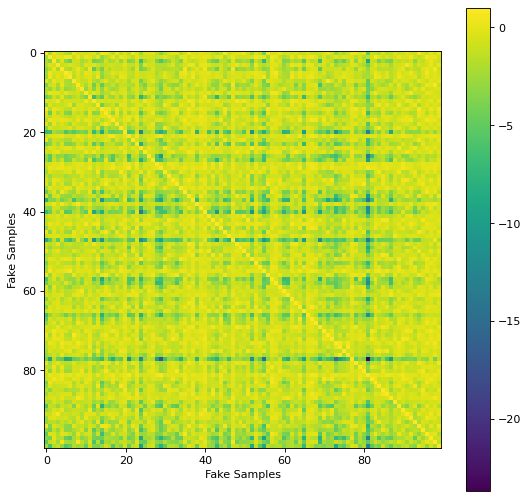

 
Average ----> -1.368


In [87]:
#KL-pq
#En palabras, es el promedio ponderado de la diferencia 
#logarítmica entre las probabilidades P y Q,
#donde el promedio se toma usando las probabilidades P
print('In Real-Real and Fake-Fake matrix values of equal')
print('distributions are omited when calculating the mean')
print(' ')
print(' ')
print(' ')
print('Variance real-fake:')
print(' ')
print(np.around(var_matrix_pq, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(var_matrix_pq)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Real Samples')
plt.show()
print(' ')
var_matrix_pq[var_matrix_pq == 0] = np.nan
print('Average ---->', np.around(np.nanmean(var_matrix_pq), decimals=3))
print(' ')
print(' ')
print(' ')
print('Variance real-real:')
print(' ')
print(np.around(np.mean(var_matrix_pq_real), decimals=3))
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(var_matrix_pq_real)
plt.colorbar()
plt.xlabel('Real Samples')
plt.ylabel('Real Samples')
plt.show()
print(' ')
var_matrix_pq_real[var_matrix_pq_real == 0] = np.nan
print('Average ---->', np.around(np.nanmean(var_matrix_pq_real), decimals=3))
print(' ')
print(' ')
print(' ')
print('Variance fake-fake:')
print(' ')
print(np.around(var_matrix_pq_fake, decimals=3))
print(' ')
figure(figsize=(img_size, img_size), dpi=80)
plt.imshow(var_matrix_pq_fake)
plt.colorbar()
plt.xlabel('Fake Samples')
plt.ylabel('Fake Samples')
plt.show()
print(' ')
var_matrix_pq_fake[var_matrix_pq_fake == 0] = np.nan
print('Average ---->', np.around(np.nanmean(var_matrix_pq_fake), decimals=3))

In [88]:
print('Mean Absolute Deviation:')
print(' ')
#print('Fake:',np.around(mad_matrix_fake, decimals=3))
#print(' ')
print('Average Fake ---->', np.around(np.mean(mad_matrix_fake),decimals=3))
#print(' ')
#print(' ')
#print('Real',np.around(mad_matrix_real, decimals=3))
#print(' ')
print('Average Real ---->',np.around(np.mean(mad_matrix_real),decimals=3))
print(' ')
print(' ')
#print(' ')
print('Standard Deviation:')
print(' ')
#print('Fake:',np.around(sd_matrix_fake, decimals=3))
#print(' ')
print('Average Fake ---->', np.around(np.mean(sd_matrix_fake),decimals=3))
#print(' ')
#print(' ')
#print('Real',np.around(sd_matrix_real, decimals=3))
#print(' ')
print('Average Real ---->',np.around(np.mean(sd_matrix_real),decimals=3))

Mean Absolute Deviation:
 
Average Fake ----> 65.407
Average Real ----> 52.841
 
 
Standard Deviation:
 
Average Fake ----> 79.162
Average Real ----> 63.11


Text(0, 0.5, 'Glucose')

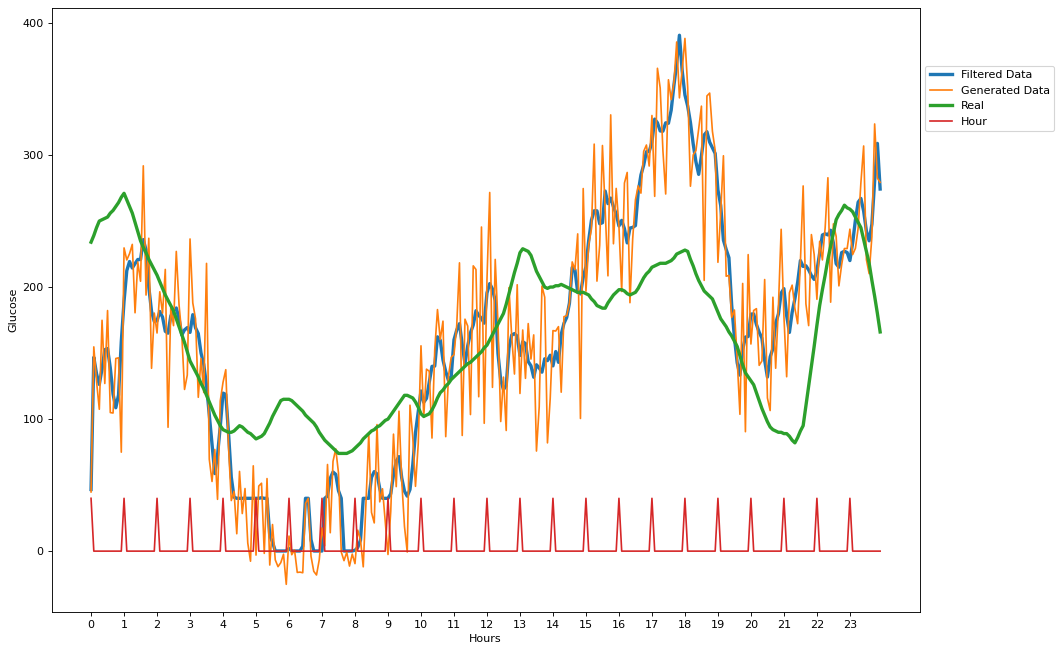

In [89]:
a=5
hourtick=np.zeros((x_real.shape[1]))
xaxis=[]
xaxis_label=[]
for j in range(x_real.shape[1]):
    if j%12==0:
        hourtick[j]=40
        xaxis.append(j)
        xaxis_label.append(int(j/12))
        
#xaxis_label=str(xaxis_label)        

#plt.scatter(x_axis,x_fake[1])
figure(figsize=(14, 10), dpi=80)
plt.plot(fake_smooth[a], label='Filtered Data',linewidth=3.0)
plt.plot(x_fake[a],label = 'Generated Data')
plt.plot(x_real[a],label = 'Real',linewidth=3.0)
plt.plot(hourtick, label = 'Hour')
plt.legend(loc='center left', bbox_to_anchor=(1,0.85))
plt.xticks(xaxis,xaxis_label)
plt.xlabel('Hours')
plt.ylabel('Glucose')

In [90]:
n_samples=64
#x_fake, y_fake = generate_fake_samples(model, latent_dim, n_samples)
#x_real, y_real = generate_real_samples(dataset, n_samples)

#x_fake=scaler.inverse_transform(x_fake)
#x_real=scaler.inverse_transform(x_real)

to_severe=0
to_topval=0

#fake_smooth = fake_smoothing(x_fake)
total=fake_smooth.shape[0]*fake_smooth.shape[1]
'''real_non_valid = hypocountrealscale(fake_smooth)[2]
for i in range(fake_smooth.shape[0]):
    for j in range(fake_smooth.shape[1]):
        if fake_smooth[i][j] <40 and fake_smooth[i][j]>30:
            to_severe = to_severe+1 
            fake_smooth[i][j] = 41

        
        elif fake_smooth[i][j] > 500 and fake_smooth[i][j]<=600:
            fake_smooth[i][j] = 500
            to_topval=to_topval+1'''        

print('Data Outside Range [40-500], not cleaned ---->',(hypocountrealscale(fake_smooth)[5]),'/',n_samples, '---->', (hypocountrealscale(fake_smooth)[5])/n_samples,'%')
print(' ')
print('Data Outside the Range not considered as data with Hypos')
print(' ')
print('Real Data Hypos:')
print('Miled Hypo ---->',hypocountrealscale(x_real)[1], '---->', 100*hypocountrealscale(x_real)[1]/total,'%')
print('Severe Hypo ---->',(hypocountrealscale(x_real)[2]+hypocountrealscale(x_real)[3]), '---->', 100*(hypocountrealscale(x_real)[2]+hypocountrealscale(x_real)[3])/total,'%')
print('NO Hypo ---->',hypocountrealscale(x_real)[0], '---->', 100*hypocountrealscale(x_real)[0]/total,'%')

print(' ')
print('Fake Data Hypos:')
print('Miled Hypo ---->',hypocountrealscale(fake_smooth)[1], '---->', 100*hypocountrealscale(fake_smooth)[1]/total,'%')
print('Severe Hypo ---->',(hypocountrealscale(fake_smooth)[2]+hypocountrealscale(fake_smooth)[3]), '---->', 100*(hypocountrealscale(fake_smooth)[2]+hypocountrealscale(fake_smooth)[3])/total,'%')
print('NO Hypo ---->',hypocountrealscale(fake_smooth)[0], '---->', 100*hypocountrealscale(fake_smooth)[0]/total,'%')

Data Outside Range [40-500], not cleaned ----> 1 / 64 ----> 0.015625 %
 
Data Outside the Range not considered as data with Hypos
 
Real Data Hypos:
Miled Hypo ----> 1219 ----> 4.232638888888889 %
Severe Hypo ----> 1032 ----> 3.5833333333333335 %
NO Hypo ----> 26521 ----> 92.08680555555556 %
 
Fake Data Hypos:
Miled Hypo ----> 642 ----> 2.2291666666666665 %
Severe Hypo ----> 789 ----> 2.7395833333333335 %
NO Hypo ----> 26682 ----> 92.64583333333333 %


In [91]:
severe_real=(hypocountrealscale(x_real)[2]+hypocountrealscale(x_real)[3])
severe_fake=(hypocountrealscale(fake_smooth)[2]+hypocountrealscale(fake_smooth)[3])
print('ERROR:')
print('Miled Hypo ---->', 100*abs(hypocountrealscale(x_real)[1]-hypocountrealscale(fake_smooth)[1])/hypocountrealscale(x_real)[1],'%')
print('Severe Hypo ---->',100*abs(severe_real-severe_fake)/severe_real,'%')
print('NO Hypo ---->',100*abs(hypocountrealscale(x_real)[0]-hypocountrealscale(fake_smooth)[0])/hypocountrealscale(x_real)[0],'%')


ERROR:
Miled Hypo ----> 47.333880229696476 %
Severe Hypo ----> 23.546511627906977 %
NO Hypo ----> 0.6070660985634025 %


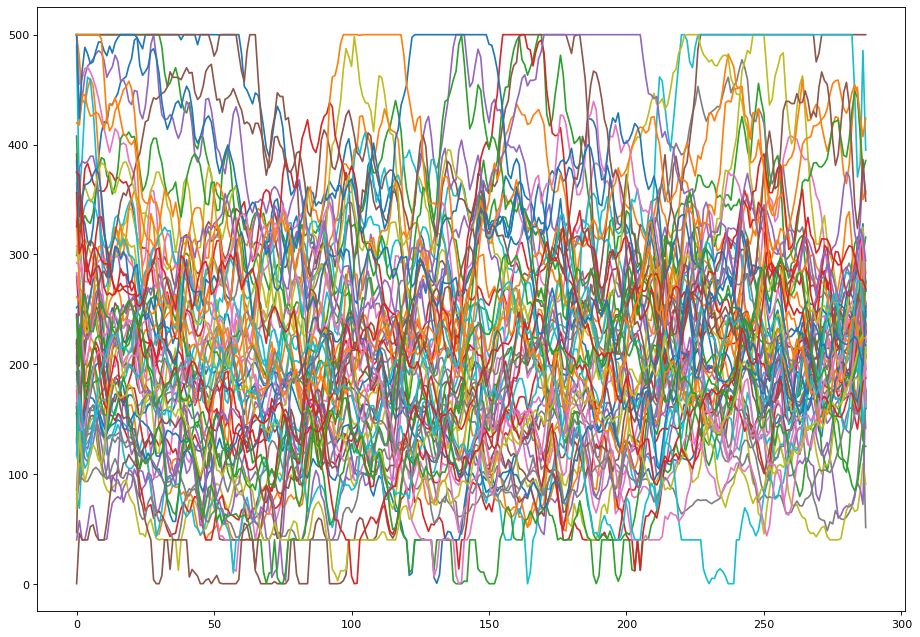

In [92]:
figure(figsize=(14, 10), dpi=80)
for i in range(n_samples):
    
    plt.plot(fake_smooth[i])
plt.show()